# Function 

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 15 01:36:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import os
seed = 0
os.environ['PYTHONHASHSEED']=str(seed)


In [ ]:
import pandas as pd
import numpy as np
import cv2
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import random as rn
from sklearn.preprocessing import  StandardScaler
# import sys
# !{sys.executable} -m pip install torchvision

In [ ]:
# import sys    
# !{sys.executable} -m pip install hypopt

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [ ]:
import tensorflow as tf

# tf.enable_eager_execution()
# tf.config.run_functions_eagerly(True)
# tf.compat.v1.enable_eager_execution()
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten , Input ,BatchNormalization, Concatenate, Layer , Maximum , Softmax
from tensorflow.keras.layers import  GlobalAveragePooling2D, AveragePooling2D , Conv1D , MaxPooling1D, Average, Dropout, LayerNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, GRU, ReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,balanced_accuracy_score
import joblib

# from keras.applications import vgg16
# from keras.applications.efficientnet import EfficientNetB3 


from tensorflow.keras.applications import ResNet50, EfficientNetB2, MobileNetV3Large

In [ ]:
# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier

# import pytorch_tabnet
# from pytorch_tabnet.tab_model import TabNetClassifier
# import torch

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
def model_1concat_gating(shape1, shape2 , all_list_filters, list_num_experts, same_seed = True):
    
    def set_seed(num_seed): 
        SEED = num_seed 
        # os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
        # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        # sess = tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_conf)
        # K.set_session(sess)
        
    def expert_block(inputs , num_filters,  num_seed):
        set_seed(num_seed)
        conv = Conv2D(filters = num_filters[0],
                      kernel_size = (3,3) ,
                      activation = tf.nn.relu )(inputs)
        conv = MaxPooling2D(pool_size=(2, 2))(conv)
        conv = BatchNormalization()(conv)
        if  1 <= len(num_filters[1:]) <= 3  :
            for num_filter in num_filters[1:] :
                conv = Conv2D(filters = num_filter,
                              kernel_size = (3,3) ,
                              activation = tf.nn.relu,
                              padding = 'same')(conv)
                conv = MaxPooling2D(pool_size=(2, 2))(conv)
                conv = BatchNormalization()(conv)
        elif len(num_filters[1:]) >= 4 :
            for num_filter in num_filters[1:] :
                conv = Conv2D(filters = num_filter,
                              kernel_size = (3,3) ,
                              activation = tf.nn.relu,
                              padding = 'same')(conv)
                conv = BatchNormalization()(conv)

            
        #-------------------------------------------------- 
        conv = Flatten()(conv)
        conv = Dense(units =  1000,
                     activation = tf.nn.relu)(conv)
        conv = BatchNormalization()(conv)
        #-----------------------------         
        conv = Dense(units =  600,
                     activation = tf.nn.relu)(conv)
        conv = BatchNormalization()(conv)
        conv = Dropout(rate = 0.2)(conv)
        y_hat = Dense(units = 12,
                      activation = None)(conv)
        return y_hat
    
    def Mixture_of_Experts(inputs,list_num_filters , num_experts, names) :
        assert len(list_num_filters) == num_experts
        num_seed = 0
        expert_outs = []
        for i in range(num_experts):
            if same_seed :
                expert_network = expert_block(inputs, list_num_filters[i], num_seed )
            else :
                expert_network = expert_block(inputs, list_num_filters[i], i )
            expert_outs.append(expert_network)
        expert_concat = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=1))(expert_outs)
        print('expert concat shape : ', expert_concat.shape)
        # gating network 
        gating = Conv2D(filters = 30,
                      kernel_size = (3,3) ,
                      activation = tf.nn.relu )(inputs)
        gating = MaxPooling2D(pool_size=(2, 2))(gating)
        gating = BatchNormalization()(gating)
        gating = Flatten()(gating)
        # ------------------------------------------------
        gating = Dense(800, activation = tf.nn.relu)(gating)
        gating = BatchNormalization()(gating)
        gating = Dropout(rate = 0.2)(gating)
        # -----------------
        gating = Dense(1200, activation = tf.nn.relu)(gating)
        gating = BatchNormalization()(gating)
        gating = Dropout(rate = 0.2)(gating)
        # -----------------
        gating = Dense(num_experts, activation = tf.nn.softmax)(gating)
        gating = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(gating)
        gate_mul_expert = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x[0] * x[1], axis=1),
                                                 name='gate_mul_expert_' + names )([expert_concat, gating])
        gate_mul_expert = tf.keras.layers.Softmax()(gate_mul_expert)
        print('gate mul expert : ', gate_mul_expert.shape)

        return gate_mul_expert
    
    assert len(all_list_filters) == list_num_experts
    names = '0'
    set_seed(0)
    #------------------------------------------
    input = Input(shape = (shape1, shape2, 1))
    output = Mixture_of_Experts(input, all_list_filters , list_num_experts,names)
    #------------------------------------------
#     concat = Concatenate(axis=1)([MoE_1, MoE_2, MoE_3])
#     concat = Dense(units = 600,
#                    activation = tf.nn.relu)(MoE_1)
#     concat = BatchNormalization()(concat)
#     concat = Dropout(0.25)(concat)
#     concat = Dense(units = 1000 ,
#                    activation = tf.nn.relu)(concat)
#     concat = BatchNormalization()(concat)
#     concat = Dropout(0.25)(concat)
#     softmax = Dense(12, activation = tf.nn.softmax )(concat)



    
    model = Model(inputs=[input], outputs=output)
    return model


In [ ]:
def model_2concat_gating(shape1, shape2 , all_list_filters_0, all_list_filters_1, list_num_experts_0, list_num_experts_1, 
                         same_seed = [True,True], method = 'concat'):
    
    def set_seed(num_seed): 
        SEED = num_seed 
        # os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        # tf.compat.v1.keras.backend.set_session(sess)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
        
    def expert_block(inputs , num_filters,  num_seed):
        set_seed(num_seed)
        conv = Conv2D(filters = num_filters[0],
                      kernel_size = (3,3) ,
                      activation = tf.nn.relu )(inputs)
        conv = MaxPooling2D(pool_size=(2, 2))(conv)
        conv = BatchNormalization()(conv)
        if  1 <= len(num_filters[1:]) <= 3  :
            for num_filter in num_filters[1:] :
                conv = Conv2D(filters = num_filter,
                              kernel_size = (3,3) ,
                              activation = tf.nn.relu,
                              padding = 'same')(conv)
                conv = MaxPooling2D(pool_size=(2, 2))(conv)
                conv = BatchNormalization()(conv)
        elif len(num_filters[1:]) >= 4 :
            for num_filter in num_filters[1:] :
                conv = Conv2D(filters = num_filter,
                              kernel_size = (3,3) ,
                              activation = tf.nn.relu,
                              padding = 'same')(conv)
                conv = BatchNormalization()(conv)

            
        #-------------------------------------------------- 
        conv = Flatten()(conv)
        conv = Dense(units =  1000,
                     activation = tf.nn.relu)(conv)
        conv = BatchNormalization()(conv)
        #-----------------------------         
        conv = Dense(units =  600,
                     activation = tf.nn.relu)(conv)
        conv = BatchNormalization()(conv)
        conv = Dropout(rate = 0.2)(conv)
        y_hat = Dense(units = 12,
                      activation = None)(conv)
        return y_hat
    
    def Mixture_of_Experts(inputs,list_num_filters , num_experts, names, same_seed) :
        assert len(list_num_filters) == num_experts
        num_seed = 0
        expert_outs = []
        for i in range(num_experts):
            if same_seed :
                expert_network = expert_block(inputs, list_num_filters[i], num_seed )
            else :
                expert_network = expert_block(inputs, list_num_filters[i], i )
            expert_outs.append(expert_network)
        expert_concat = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=1))(expert_outs)
        print('expert concat shape : ', expert_concat.shape)
        # gating network 
        gating = Conv2D(filters = 30,
                      kernel_size = (3,3) ,
                      activation = tf.nn.relu )(inputs)
        gating = MaxPooling2D(pool_size=(2, 2))(gating)
        gating = BatchNormalization()(gating)
        gating = Flatten()(gating)
        # ------------------------------------------------
        gating = Dense(800, activation = tf.nn.relu)(gating)
        gating = BatchNormalization()(gating)
        gating = Dropout(rate = 0.2)(gating)
        # -----------------
        gating = Dense(1200, activation = tf.nn.relu)(gating)
        gating = BatchNormalization()(gating)
        gating = Dropout(rate = 0.2)(gating)
        # -----------------
        gating = Dense(num_experts, activation = tf.nn.softmax)(gating)
        gating = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(gating)
        gate_mul_expert = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x[0] * x[1], axis=1),
                                                 name='gate_mul_expert_' + names )([expert_concat, gating])
#         gate_mul_expert = tf.keras.layers.Softmax()(gate_mul_expert)
        print('gate mul expert : ', gate_mul_expert.shape)

        return gate_mul_expert
    
    assert (len(all_list_filters_0) + len(all_list_filters_1)) == list_num_experts_0 + list_num_experts_1
    assert len(all_list_filters_0) == list_num_experts_0
    assert len(all_list_filters_1) == list_num_experts_1
    names = ['1','2']
    set_seed(0)
    #------------------------------------------
    input1 = Input(shape = (shape1, shape2, 1))
    MoE_1 = Mixture_of_Experts(input1, all_list_filters_0 , list_num_experts_0,names[0],same_seed[0])
    input2 = Input(shape = (shape1, shape2, 1))
    MoE_2 = Mixture_of_Experts(input2, all_list_filters_1 , list_num_experts_1,names[1],same_seed[1])
    #------------------------------------------
    if method == 'concat':
        concat = Concatenate(axis=1)([MoE_1, MoE_2])
        concat = Dense(units = 600,
                       activation = tf.nn.relu)(concat)
        concat = BatchNormalization()(concat)
        concat = Dropout(0.25)(concat)
        concat = Dense(units = 1000 ,
                       activation = tf.nn.relu)(concat)
        concat = BatchNormalization()(concat)
        concat = Dropout(0.25)(concat)
        softmax = Dense(12, activation = tf.nn.softmax )(concat)
    elif method == 'max':
#         MoE_1 = Softmax()(MoE_1)
#         MoE_2 = Softmax()(MoE_2)
        maxs = Maximum()([MoE_1,MoE_2])
        softmax = Softmax()(maxs)
    elif method == 'average':
#         MoE_1 = Softmax()(MoE_1)
#         MoE_2 = Softmax()(MoE_2)
        average = Average()([MoE_1,MoE_2])
        softmax = Softmax()(average)
    else :
        print('Wrong method')
        return False
    #------------------------------------------
    model = Model(inputs=[input1,input2], outputs=softmax)
    return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SUB = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Journal/raw/sensor.csv', skiprows = 1)
SUB.head()

,Time,X-axis Accelerometer (g),Y-axis Accelerometer (g),Z-axis Accelerometer (g),Roll Gyroscrope (deg/s),Pitch Gyroscope (deg/s),Yaw Gyroscope (deg/s),Luminosity (lux),X-axis Accelerometer (g).1,Y-axis Accelerometer (g).1,...,Yaw Gyroscope (deg/s).4,Luminosity (lux).4,Raw Brainwave Signal,Infrared 1,Infrared 2,Infrared 3,Infrared 4,Infrared 5,Infrared 6,Label
0,2018-07-04T12:04:17.738369,-1.005,0.229,-0.083,-0.671,0.488,-2.683,0.0,-0.981,0.260,...,315.915,2108.154,45.0,1,1,1,1,1,1,7
1,2018-07-04T12:04:17.790509,-1.005,0.228,-0.082,-3.415,-0.549,0.122,0.0,-0.981,0.260,...,344.146,2108.154,1.0,1,1,1,1,1,1,7
2,2018-07-04T12:04:17.836632,-1.005,0.231,-0.079,-2.622,-1.402,-0.549,0.0,-0.975,0.282,...,372.012,2108.154,325.0,1,1,1,1,1,1,7
3,2018-07-04T12:04:17.885262,-1.005,0.231,-0.079,-2.561,-2.195,-1.220,0.0,-0.973,0.301,...,356.463,2108.154,396.0,1,1,1,1,1,1,7
4,2018-07-04T12:04:17.945423,-1.008,0.229,-0.072,-3.537,-2.073,-0.305,0.0,-0.973,0.301,...,126.768,2108.154,-436.0,1,1,1,1,1,1,7


In [ ]:
print(SUB.shape)

(294678, 44)


# Data Processing

In [ ]:
SUB.isnull().sum()

Time                              0
X-axis Accelerometer (g)          0
Y-axis Accelerometer (g)          0
Z-axis Accelerometer (g)          0
Roll Gyroscrope (deg/s)           0
Pitch Gyroscope (deg/s)           0
Yaw Gyroscope (deg/s)             0
Luminosity (lux)                  0
X-axis Accelerometer (g).1    36109
Y-axis Accelerometer (g).1    36109
Z-axis Accelerometer (g).1    36109
Roll Gyroscrope (deg/s).1     36109
Pitch Gyroscope (deg/s).1     36109
Yaw Gyroscope (deg/s).1       36109
Luminosity (lux).1            36109
X-axis Accelerometer (g).2        0
Y-axis Accelerometer (g).2        0
Z-axis Accelerometer (g).2        0
Roll Gyroscrope (deg/s).2         0
Pitch Gyroscope (deg/s).2         0
Yaw Gyroscope (deg/s).2           0
Luminosity (lux).2                0
X-axis Accelerometer (g).3        0
Y-axis Accelerometer (g).3        0
Z-axis Accelerometer (g).3        0
Roll Gyroscrope (deg/s).3         0
Pitch Gyroscope (deg/s).3         0
Yaw Gyroscope (deg/s).3     

In [ ]:
NA_cols  = SUB.columns[SUB.isnull().any()]
print('Columns contain NULL values : \n', NA_cols )


SUB.dropna(inplace = True)
SUB.drop_duplicates(inplace = True)
print('Sensor Data shape after dropping NaN and redudant samples :',SUB.shape)


times = SUB['Time']

list_DROP = [ 'Infrared 1', 
              'Infrared 2', 
              'Infrared 3', 
              'Infrared 4', 
              'Infrared 5', 
              'Infrared 6']
SUB.drop(list_DROP, axis = 1, inplace=  True )
SUB.drop( NA_cols, axis = 1, inplace=  True ) # drop NAN COLS

print('Sensor Data shape after dropping columns contain NaN values :',SUB.shape)

Columns contain NULL values : 
 Index(['X-axis Accelerometer (g).1', 'Y-axis Accelerometer (g).1',
       'Z-axis Accelerometer (g).1', 'Roll Gyroscrope (deg/s).1',
       'Pitch Gyroscope (deg/s).1', 'Yaw Gyroscope (deg/s).1',
       'Luminosity (lux).1', 'Raw Brainwave Signal '],
      dtype='object')
Sensor Data shape after dropping NaN and redudant samples : (258114, 44)
Sensor Data shape after dropping columns contain NaN values : (258114, 30)


In [ ]:
SUB.set_index('Time', inplace = True)
SUB.head()

,X-axis Accelerometer (g),Y-axis Accelerometer (g),Z-axis Accelerometer (g),Roll Gyroscrope (deg/s),Pitch Gyroscope (deg/s),Yaw Gyroscope (deg/s),Luminosity (lux),X-axis Accelerometer (g).2,Y-axis Accelerometer (g).2,Z-axis Accelerometer (g).2,...,Yaw Gyroscope (deg/s).3,Luminosity (lux).3,X-axis Accelerometer (g).4,Y-axis Accelerometer (g).4,Z-axis Accelerometer (g).4,Roll Gyroscrope (deg/s).4,Pitch Gyroscope (deg/s).4,Yaw Gyroscope (deg/s).4,Luminosity (lux).4,Label
Time,,,,,,,,,,,,,,,,,,,,,
2018-07-04T12:04:17.738369,-1.005,0.229,-0.083,-0.671,0.488,-2.683,0.0,0.146,0.895,0.367,...,9.207,1231.336,-1.240,-0.557,0.227,-75.854,44.024,315.915,2108.154,7
2018-07-04T12:04:17.790509,-1.005,0.228,-0.082,-3.415,-0.549,0.122,0.0,0.146,0.895,0.367,...,5.122,1231.336,-1.240,-0.557,0.227,-28.780,55.549,344.146,2108.154,7
2018-07-04T12:04:17.836632,-1.005,0.231,-0.079,-2.622,-1.402,-0.549,0.0,0.178,0.896,0.373,...,4.329,1231.336,-1.884,-0.687,0.251,27.256,87.134,372.012,2108.154,7
2018-07-04T12:04:17.885262,-1.005,0.231,-0.079,-2.561,-2.195,-1.220,0.0,0.160,0.895,0.372,...,0.366,1231.336,-1.884,-0.687,0.251,2.866,117.683,356.463,2108.154,7
2018-07-04T12:04:17.945423,-1.008,0.229,-0.072,-3.537,-2.073,-0.305,0.0,0.160,0.895,0.372,...,-3.232,1231.336,-1.597,-0.646,0.112,10.000,30.671,126.768,2108.154,7


In [ ]:
cam = '1'

image = '/content/drive/MyDrive/Colab Notebooks/Journal/raw/image_1.npy'       
name = '/content/drive/MyDrive/Colab Notebooks/Journal/raw/name_1.npy'
label = '/content/drive/MyDrive/Colab Notebooks/Journal/raw/label_1.npy'

img_1 = np.load(image)
label_1 = np.load(label)
name_1 = np.load(name)

cam = '2'

image = '/content/drive/MyDrive/Colab Notebooks/Journal/raw/image_2.npy'       
name = '/content/drive/MyDrive/Colab Notebooks/Journal/raw/name_2.npy'
label = '/content/drive/MyDrive/Colab Notebooks/Journal/raw/label_2.npy'

img_2 = np.load(image)
label_2 = np.load(label)
name_2 = np.load(name)



In [ ]:
print(len(img_1))
print(len(name_1))
print(len(img_2))
print(len(name_2))

294677
294677
294677
294677


In [ ]:
# remove NaN values corresponding to index sample in csv file
redundant_1 = list(set(name_1) - set(times))
redundant_2 = list(set(name_2) - set(times))
ind = np.arange(0,294677)


red_in1 = ind[np.isin(name_1,redundant_1)]
name_1 =  np.delete(name_1, red_in1)
img_1 = np.delete(img_1, red_in1, axis = 0 )
label_1 = np.delete(label_1, red_in1)

red_in2 = ind[np.isin(name_2,redundant_2)]
name_2 =  np.delete(name_2, red_in2)
img_2 = np.delete(img_2, red_in2, axis = 0 )
label_2 = np.delete(label_2, red_in2)

In [ ]:
print(len(name_2))
print(len(name_1))

258113
258113


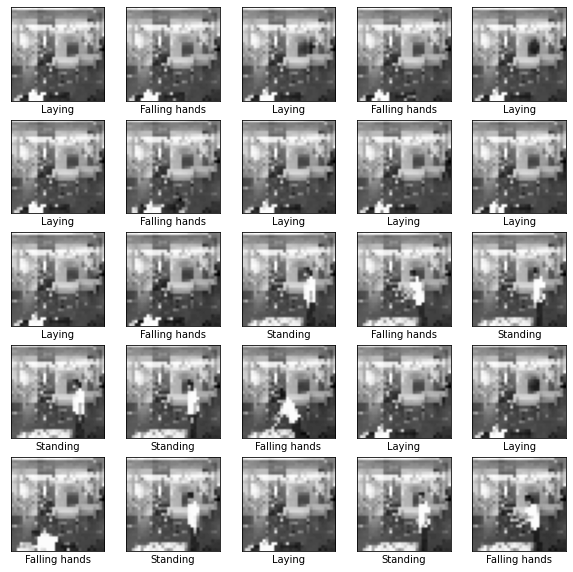

In [ ]:
class_name = [    '?????' ,
                'Falling hands' ,
                 'Falling knees' ,
                 'Falling backwards',
                 'Falling sideward' ,
                ' Falling chair',
                ' Walking',
                 'Standing' ,
                 'Sitting' ,
                 'Picking object' ,
                 'Jumping' ,
                 'Laying' ]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_1[i], cmap = 'gray')
    plt.xlabel(class_name[label_1[i]])
plt.show()

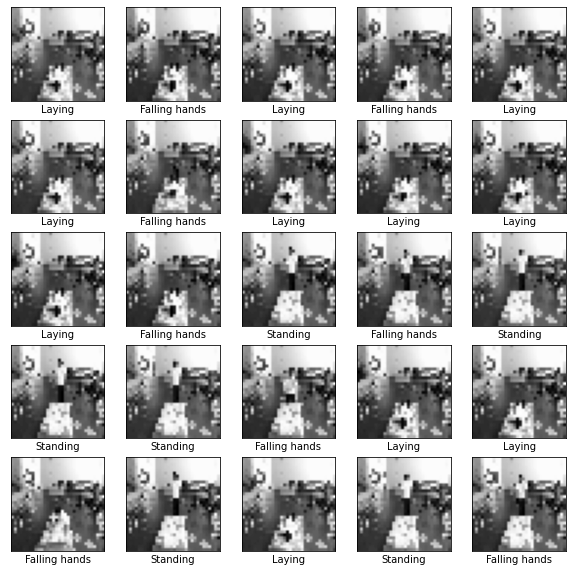

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2[i], cmap = 'gray')
    plt.xlabel(class_name[label_2[i]])
plt.show()

In [ ]:

data = SUB.loc[name_1].values
print(img_1.shape)
print(img_2.shape)
print(data.shape)


print((label_2 == data[:,-1]).all())
print((label_1 == data[:,-1]).all())

(258113, 32, 32)
(258113, 32, 32)
(258113, 29)
True
True


In [ ]:

# def set_seed(): 
#     SEED = 0 
#     os.environ['PYTHONHASHSEED']=str(SEED)
#     np.random.seed(SEED)
#     tf.random.set_seed(SEED)
#     rn.seed(SEED)
#     session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#     sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#     tf.compat.v1.keras.backend.set_session(sess)

# set_seed()
X_csv, y_csv = data[:,:-1] , data[:,-1]

y_csv = np.where(y_csv == 20 , 0, y_csv)
label_1 = np.where(label_1 == 20 , 0, label_1)
label_2 = np.where(label_2 == 20, 0, label_2)
X_train_csv,X_rem_csv,y_train_csv,y_rem_csv = train_test_split(X_csv, y_csv, 
                                                                 train_size = 0.6,
                                                                 random_state = 42)

X_val_csv, X_test_csv, y_val_csv, y_test_csv = train_test_split(X_rem_csv, y_rem_csv, 
                                                                  test_size = 0.5, 
                                                                  random_state = 42)

print('X_train_csv shape : ',X_train_csv.shape)
print('X_test_csv shape : ',X_test_csv.shape)
print('X_val_csv shape : ',X_val_csv.shape)
print('y_train_csv shape : ',y_train_csv.shape)
print('y_test_csv shape : ',y_test_csv.shape)
print('y_val_csv shape : ',y_val_csv.shape)

Y_train_csv = to_categorical(y_train_csv, 12)
Y_test_csv = to_categorical(y_test_csv, 12)
Y_val_csv = to_categorical(y_val_csv, 12)

print('Y_train_csv shape : ',Y_train_csv.shape)
print('Y_test_csv shape : ',Y_test_csv.shape)
print('Y_val_csv shape : ',Y_val_csv.shape)



X_train_1,X_rem_1,y_train_1,y_rem_1 = train_test_split(img_1,label_1,
                                                         train_size = 0.6,
                                                         random_state = 42,
                                                         )

X_val_1,X_test_1,y_val_1,y_test_1 = train_test_split(X_rem_1,y_rem_1,
                                                         test_size = 0.5,
                                                         random_state = 42,
                                                         )
print('*'*20)
print('X_train_1 shape : ',X_train_1.shape)
print('X_test_1 shape : ',X_test_1.shape)
print('X_val_1 shape : ',X_val_1.shape)
print('y_train_1 shape : ',y_train_1.shape)
print('y_test_1 shape : ',y_test_1.shape)
print('y_val_1 shape : ',y_val_1.shape)


Y_train_1 = to_categorical(y_train_1, 12)
Y_test_1 = to_categorical(y_test_1, 12)
Y_val_1 = to_categorical(y_val_1, 12)

print('Y_train_1 shape : ',Y_train_1.shape)
print('Y_test_1 shape : ',Y_test_1.shape)
print('Y_val_1 shape : ',Y_val_1.shape)



X_train_2,X_rem_2,y_train_2,y_rem_2 = train_test_split(img_2,label_2,
                                                         train_size = 0.6,
                                                         random_state = 42,
                                                         )

X_val_2,X_test_2,y_val_2,y_test_2 = train_test_split(X_rem_2,y_rem_2,
                                                         test_size = 0.5,
                                                         random_state = 42,
                                                         )

print('*'*20)
print('X_train_2 shape : ',X_train_2.shape)
print('X_test_2 shape : ',X_test_2.shape)
print('X_val_2 shape : ',X_val_2.shape)
print('y_train_2 shape : ',y_train_2.shape)
print('y_test_2 shape : ',y_test_2.shape)
print('y_val_2 shape : ',y_val_2.shape)


Y_train_2 = to_categorical(y_train_2, 12)
Y_test_2 = to_categorical(y_test_2, 12)
Y_val_2 = to_categorical(y_val_2, 12)

print('Y_train_2 shape : ',Y_train_2.shape)
print('Y_test_2 shape : ',Y_test_2.shape)
print('Y_val_2 shape : ',Y_val_2.shape)


X_train_csv shape :  (154867, 28)
X_test_csv shape :  (51623, 28)
X_val_csv shape :  (51623, 28)
y_train_csv shape :  (154867,)
y_test_csv shape :  (51623,)
y_val_csv shape :  (51623,)
Y_train_csv shape :  (154867, 12)
Y_test_csv shape :  (51623, 12)
Y_val_csv shape :  (51623, 12)
********************
X_train_1 shape :  (154867, 32, 32)
X_test_1 shape :  (51623, 32, 32)
X_val_1 shape :  (51623, 32, 32)
y_train_1 shape :  (154867,)
y_test_1 shape :  (51623,)
y_val_1 shape :  (51623,)
Y_train_1 shape :  (154867, 12)
Y_test_1 shape :  (51623, 12)
Y_val_1 shape :  (51623, 12)
********************
X_train_2 shape :  (154867, 32, 32)
X_test_2 shape :  (51623, 32, 32)
X_val_2 shape :  (51623, 32, 32)
y_train_2 shape :  (154867,)
y_test_2 shape :  (51623,)
y_val_2 shape :  (51623,)
Y_train_2 shape :  (154867, 12)
Y_test_2 shape :  (51623, 12)
Y_val_2 shape :  (51623, 12)


In [ ]:
print((y_train_1 == y_train_csv).all())
print((y_train_2 == y_train_csv).all())

print((y_val_1 == y_val_csv).all())
print((y_val_2 == y_val_csv).all())

print((y_test_1 == y_test_csv).all())
print((y_test_2 == y_test_csv).all())

True
True
True
True
True
True


In [ ]:

def display_result(y_test , y_pred) :
    print('Accuracy score : ', accuracy_score(y_test , y_pred) )
    print('Precision score : ', precision_score(y_test , y_pred, average='weighted'))
    print('Recall score : ', recall_score(y_test , y_pred, average='weighted'))
    print('F1 score : ', f1_score(y_test , y_pred, average='weighted'))
    
def display_result123(y_test , y_pred) :
    print('Accuracy score : ', accuracy_score(y_test , y_pred) )
    print('Precision score : ', precision_score(y_test , y_pred, average='macro'))
    print('Recall score : ', recall_score(y_test , y_pred, average='macro'))
    print('F1 score : ', f1_score(y_test , y_pred, average='macro'))
    
def scaled_data(X_train, X_test, X_val):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)
    return X_train_scaled, X_test_scaled , X_val_scaled


def convert_to_categorical (y_train, y_test, y_val) :
    print('--------------------------To Categorical ---------------------------')
    Y_train = to_categorical(y_train, 12)
    Y_test = to_categorical(y_test, 12)
    Y_val = to_categorical(y_val,12)
    
    print('Before    : ', y_train[0])
    print('After     : ',Y_train[0])
    return Y_train, Y_test, Y_val 


# X_train_csv_scaled, X_test_csv_scaled , X_val_csv_scaled = scaled_data(X_train_csv, X_test_csv, X_val_csv)
# Y_train_csv , Y_test_csv , Y_val_csv = convert_to_categorical (y_train_csv, y_test_csv, y_val_csv)


In [ ]:
X_train_1_scaled = X_train_1/255.0
X_train_2_scaled = X_train_2/255.0

X_val_1_scaled = X_val_1/255.0
X_val_2_scaled = X_val_2/255.0

X_test_1_scaled = X_test_1/255.0
X_test_2_scaled = X_test_2/255.0

In [ ]:
# X_train_1_scaled = X_train_1_scaled.reshape(X_train_1_scaled.shape[0],32,32,1)
# X_test_1_scaled = X_test_1_scaled.reshape(X_test_1_scaled.shape[0],32,32,1)
# X_val_1_scaled = X_val_1_scaled.reshape(X_val_1_scaled.shape[0],32,32,1)

# X_train_2_scaled = X_train_2_scaled.reshape(X_train_2_scaled.shape[0],32,32,1)
# X_test_1_scaled = X_test_2_scaled.reshape(X_test_2_scaled.shape[0],32,32,1)
# X_val_1_scaled = X_val_2_scaled.reshape(X_val_2_scaled.shape[0],32,32,1)



X_train_1_scaled = X_train_1_scaled.reshape(X_train_1_scaled.shape[0],32,32)
X_test_1_scaled = X_test_1_scaled.reshape(X_test_1_scaled.shape[0],32,32)
X_val_1_scaled = X_val_1_scaled.reshape(X_val_1_scaled.shape[0],32,32)

X_train_2_scaled = X_train_2_scaled.reshape(X_train_2_scaled.shape[0],32,32)
X_test_2_scaled = X_test_2_scaled.reshape(X_test_2_scaled.shape[0],32,32)
X_val_2_scaled = X_val_2_scaled.reshape(X_val_2_scaled.shape[0],32,32)

In [ ]:
print(X_train_1_scaled.shape)
print(X_test_1_scaled.shape)
print(X_val_1_scaled.shape)

print(X_train_2_scaled.shape)
print(X_test_2_scaled.shape)
print(X_val_2_scaled.shape)

(154867, 32, 32)
(51623, 32, 32)
(51623, 32, 32)
(154867, 32, 32)
(51623, 32, 32)
(51623, 32, 32)


In [ ]:
def take_f1_Score(y_pred, y_test) :
  k = list(f1_score(y_pred, y_test, average=None))
  ds = []
  for i in range(len(k)):
    kk = round(k[i]*100, 2)
    ds.append(kk)
  print(ds)

In [ ]:
def draw_cm (y_true,y_pred):
  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(y_true, y_pred,normalize = 'true')
  ds = []
  for i in range(len(cm)):
    kk = round(cm[i][i], 4)
    ds.append(kk)
  cm_df = pd.DataFrame(cm,
                      index = [       '?????' ,
                                      'Falling hands' ,
                                      'Falling knees' ,
                                      'Falling backwards',
                                      'Falling sideward' ,
                                      ' Falling chair',
                                      ' Walking',
                                      'Standing' ,
                                      'Sitting' ,
                                      'Picking object' ,
                                      'Jumping' ,
                                      'Laying' ], 
                      columns = [       '?????' ,
                                      'Falling hands' ,
                                      'Falling knees' ,
                                      'Falling backwards',
                                      'Falling sideward' ,
                                      ' Falling chair',
                                      ' Walking',
                                      'Standing' ,
                                      'Sitting' ,
                                      'Picking object' ,
                                      'Jumping' ,
                                      'Laying' ])


  import seaborn as sns
  sns.color_palette("tab10")
  #Plotting the confusion matrix
  plt.figure(figsize=(10,10))
  sns.heatmap(cm_df, annot=True,fmt='.2%', cmap='gist_stern_r')
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
# plt.savefig('confusion.png')
  return ds

# UP-MODEL 1

## IMG1 
[Link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6539235/)

In [ ]:
def model_1 () :
    def set_seed(num_seed): 
        SEED = num_seed 
        # os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        # tf.compat.v1.keras.backend.set_session(sess)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
      
    set_seed(0)
    input = Input(shape = (32, 32, 1))

    x = Conv2D(filters = 8,
              kernel_size = (3,3) ,
              activation = tf.nn.relu,
              padding = 'valid' )(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    for filter in [16,32] :
        x = Conv2D(filters = filter,
              kernel_size = (3,3) ,
              activation = tf.nn.relu,
              padding = 'valid' )(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    output = Dense(12, activation = 'softmax',
                   kernel_regularizer=regularizers.l1_l2(l1=0.004, l2=0.004),
                   bias_regularizer=regularizers.l2(0.004),
                   activity_regularizer=regularizers.l2(0.004))(x)
    
    model = Model(inputs= input, outputs=output)

    return model 



In [ ]:
up_model = model_1()
# up_model.summary()

up_model.compile(
#                  optimizer = tf.keras.optimizers.RMSprop(7e-5), 
#                  optimizer = tf.keras.optimizers.Adam(7e-5),
                #  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-08, decay=0.0),
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD"),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )

f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_1_1.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')

# history_2 = up_model.fit(x = X_train_1_scaled , 
#                       y=  Y_train_1,           
#                       epochs= 30, 
#                       batch_size = 100 , 
#                       validation_data = (X_val_1_scaled , Y_val_1),
#                       callbacks = [f1_callback_concat]
#                      )



print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_1_1.hdf5")
print(up_model.evaluate(X_val_1_scaled , Y_val_1))
print(up_model.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(up_model.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)


print(y_test)

dd = draw_cm(y_test_1,y_test)
print(dd)


best model: 
1054/1614 [==================>...........] - ETA: 2s - loss: 0.8366 - categorical_accuracy: 0.7868 - precision: 0.8512 - recall: 0.6956 - f1_score: 0.7659

KeyboardInterrupt: ignored

In [ ]:

print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_1_1.hdf5")
print(up_model.evaluate(X_val_1_scaled , Y_val_1))
print(up_model.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(up_model.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)


# 78.49, 74.92, 78.49, 76.33

best model: 
1614/1614 [==============================] - 8s 5ms/step - loss: 0.8363 - categorical_accuracy: 0.7876 - precision: 0.8514 - recall: 0.6974 - f1_score: 0.7663
[0.8362922072410583, 0.7876140475273132, 0.8514401912689209, 0.697441041469574, 0.7663437724113464]
1614/1614 [==============================] - 8s 5ms/step - loss: 0.8383 - categorical_accuracy: 0.7849 - precision: 0.8481 - recall: 0.6981 - f1_score: 0.7633
[0.8382644653320312, 0.7849020957946777, 0.8480527400970459, 0.698099672794342, 0.7632587552070618]
Accuracy score :  0.7876140480018596
Precision score :  0.7523018621746512
Recall score :  0.7876140480018596
F1 score :  0.7663437580111035
********************


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score :  0.7849020785308874
Precision score :  0.7492486658548093
Recall score :  0.7849020785308874
F1 score :  0.763258733845493


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## IMG2

In [ ]:
up_model = model_1()
up_model.summary()




up_model.compile(
#                  optimizer = tf.keras.optimizers.RMSprop(7e-5), 
#                  optimizer = tf.keras.optimizers.Adam(7e-5),
                #  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-08, decay=0.0),
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD"),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )

f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_1_2.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')

history_2 = up_model.fit(x = X_train_2_scaled , 
                      y=  Y_train_2,           
                      epochs= 30, 
                      batch_size = 100 , 
                      validation_data = (X_val_2_scaled , Y_val_2),
                      callbacks = [f1_callback_concat]
                     )


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 30, 30, 8)         80        
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 15, 15, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 13, 13, 16)        1168      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 32)          4640

In [ ]:
print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_1_2.hdf5")
print(up_model.evaluate(X_val_2_scaled , Y_val_2))
print(up_model.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(up_model.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)


# 87.93, 84.7, 87.93, 86.69

best model: 
1614/1614 [==============================] - 8s 5ms/step - loss: 0.5309 - categorical_accuracy: 0.8795 - precision: 0.9010 - recall: 0.8590 - f1_score: 0.8572
[0.5309261083602905, 0.8795110583305359, 0.9009894728660583, 0.8589969873428345, 0.8571948409080505]
1614/1614 [==============================] - 7s 5ms/step - loss: 0.5306 - categorical_accuracy: 0.8793 - precision: 0.9013 - recall: 0.8595 - f1_score: 0.8569
[0.5306347608566284, 0.8793173432350159, 0.9012837409973145, 0.8595393300056458, 0.8569369316101074]
Accuracy score :  0.8795110706468047
Precision score :  0.8466617786517519
Recall score :  0.8795110706468047
F1 score :  0.8571948600902658
********************


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score :  0.8793173585417353
Precision score :  0.8469829678597897
Recall score :  0.8793173585417353
F1 score :  0.8569369286124651


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# UP -2  
[link](https://sci-hub.se/10.1016/j.compbiomed.2019.103520)

In [ ]:
def model_2 () :
    def set_seed(num_seed): 
        SEED = num_seed 
        # os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        # tf.compat.v1.keras.backend.set_session(sess)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
      
    set_seed(0)
    input = Input(shape = (32, 32, 1))

    x = Conv2D(filters = 128,
              kernel_size = (3,3) ,
              activation = tf.nn.relu,
              padding = 'valid' )(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    for filter in [128,64] :
        x = Conv2D(filters = filter,
              kernel_size = (3,3) ,
              activation = tf.nn.relu,
              padding = 'valid' )(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(256, activation = 'relu')(x)
    output = Dense(12, activation = 'softmax',
                   kernel_regularizer=regularizers.l1_l2(l1=0.004, l2=0.004),
                   bias_regularizer=regularizers.l2(0.004),
                   activity_regularizer=regularizers.l2(0.004))(x)
    
    model = Model(inputs= input, outputs=output)

    return model 



## IMG1 

best model: 
1614/1614 [==============================] - 16s 10ms/step - loss: 0.0856 - categorical_accuracy: 0.9762 - precision: 0.9892 - recall: 0.9685 - f1_score: 0.9727
[0.08557366579771042, 0.9761927723884583, 0.9891775250434875, 0.968483030796051, 0.9727330803871155]
1614/1614 [==============================] - 17s 11ms/step - loss: 0.0864 - categorical_accuracy: 0.9758 - precision: 0.9889 - recall: 0.9693 - f1_score: 0.9719
[0.0863587036728859, 0.9758440852165222, 0.9889321327209473, 0.9692772626876831, 0.9718956351280212]
Accuracy score :  0.9761927822869652
Precision score :  0.9709134808936196
Recall score :  0.9761927822869652
F1 score :  0.9727331034595226
********************


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score :  0.9758441004978401
Precision score :  0.9696716438589845
Recall score :  0.9758441004978401
F1 score :  0.9718955978980658
[ 7  8  8 ...  2 10 10]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


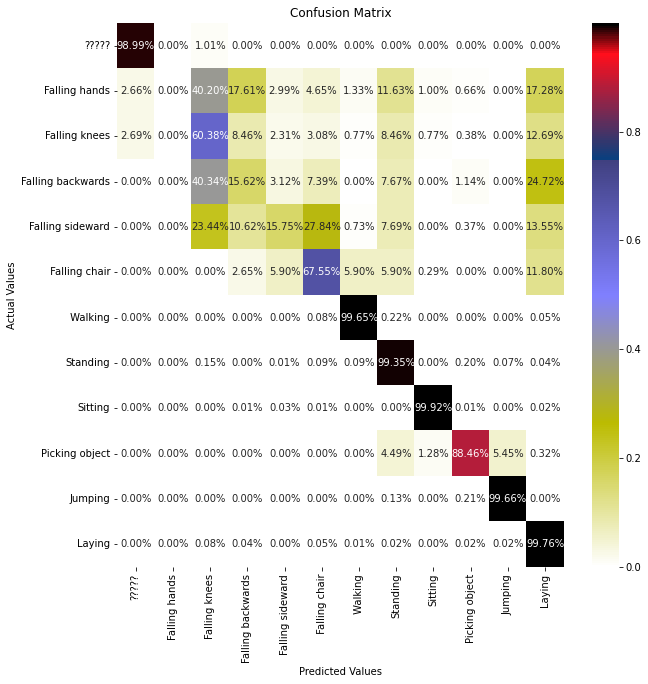

[0.9899, 0.0, 0.6038, 0.1562, 0.1575, 0.6755, 0.9965, 0.9935, 0.9992, 0.8846, 0.9966, 0.9976]
[97.04, 0.0, 40.52, 20.87, 23.5, 63.79, 99.61, 98.94, 99.91, 87.2, 99.53, 98.98]


In [ ]:

up_model = model_2()
# up_model.summary()

up_model.compile(
#                  optimizer = tf.keras.optimizers.RMSprop(7e-5), 
                 optimizer = tf.keras.optimizers.Adam(),
                #  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-08, decay=0.0),
                #  optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD"),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )

f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_1.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')

# history_2 = up_model.fit(x = X_train_1_scaled , 
#                       y=  Y_train_1,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = (X_val_1_scaled , Y_val_1),
#                       callbacks = [f1_callback_concat]
#                      )

print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_1.hdf5")
print(up_model.evaluate(X_val_1_scaled , Y_val_1))
print(up_model.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(up_model.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)

print(y_test)

dd = draw_cm(y_test_1,y_test)
print(dd)

take_f1_Score(y_test_1,y_test)

## VGG 16

In [ ]:
def vggg() :
    from keras.layers.pooling import GlobalMaxPooling2D


    def set_seed(num_seed): 
        SEED = num_seed 
        # os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        # tf.compat.v1.keras.backend.set_session(sess)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
      
    set_seed(0)
    img_input = Input(shape=(32,32,1))
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1',use_bias=True)(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    x = GlobalMaxPooling2D()(x)

    # Block 6
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(12, activation='softmax', name='predictions')(x)

    mdl = Model(img_input, x)

    return mdl

up_model = vggg()
up_model.summary()


up_model.compile(
#                  optimizer = tf.keras.optimizers.RMSprop(7e-5), 
                 optimizer = tf.keras.optimizers.Adam(),
                #  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-08, decay=0.0),
                #  optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD"),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )

f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_vgg_1.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')

history_2 = up_model.fit(x = X_train_1_scaled , 
                      y=  Y_train_1,           
                      epochs= 30, 
                      batch_size = 2**10 , 
                      validation_data = (X_val_1_scaled , Y_val_1),
                      callbacks = [f1_callback_concat]
                     )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_vgg_1.hdf5")
print(up_model.evaluate(X_val_1_scaled , Y_val_1))
print(up_model.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(up_model.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)

best model: 
1614/1614 [==============================] - 14s 9ms/step - loss: 1.7453 - categorical_accuracy: 0.2777 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1207
[1.7453112602233887, 0.2777444124221802, 0.0, 0.0, 0.12074708938598633]
1614/1614 [==============================] - 14s 8ms/step - loss: 1.7436 - categorical_accuracy: 0.2787 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1215
[1.7436041831970215, 0.27865487337112427, 0.0, 0.0, 0.12145347893238068]
Accuracy score :  0.2777444162485714
Precision score :  0.07714196075725968
Recall score :  0.2777444162485714
F1 score :  0.12074709116514354
********************


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score :  0.2786548631423978
Precision score :  0.07764853275290844
Recall score :  0.2786548631423978
F1 score :  0.1214534664375043


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
up_model = vggg()
up_model.summary()


up_model.compile(
#                  optimizer = tf.keras.optimizers.RMSprop(7e-5), 
                 optimizer = tf.keras.optimizers.Adam(),
                #  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-08, decay=0.0),
                #  optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD"),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )

f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_vgg_2.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')

history_2 = up_model.fit(x = X_train_2_scaled , 
                      y=  Y_train_2,           
                      epochs= 30, 
                      batch_size = 2**10 , 
                      validation_data = (X_val_2_scaled , Y_val_2),
                      callbacks = [f1_callback_concat]
                     )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_vgg_2.hdf5")
print(up_model.evaluate(X_val_2_scaled , Y_val_2))
print(up_model.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(up_model.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)

best model: 
1614/1614 [==============================] - 14s 8ms/step - loss: 1.7453 - categorical_accuracy: 0.2777 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1207
[1.7452805042266846, 0.2777444124221802, 0.0, 0.0, 0.12074708938598633]
1614/1614 [==============================] - 14s 9ms/step - loss: 1.7436 - categorical_accuracy: 0.2787 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1215
[1.7435693740844727, 0.27865487337112427, 0.0, 0.0, 0.12145347893238068]
Accuracy score :  0.2777444162485714
Precision score :  0.07714196075725968
Recall score :  0.2777444162485714
F1 score :  0.12074709116514354
********************


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score :  0.2786548631423978
Precision score :  0.07764853275290844
Recall score :  0.2786548631423978
F1 score :  0.1214534664375043


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## IMG2

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 128)       1280      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          7379

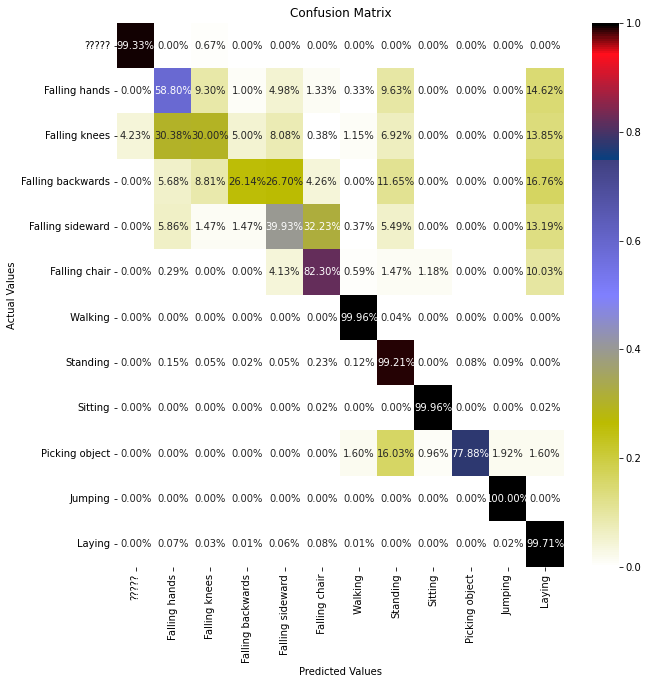

[0.9933, 0.588, 0.3, 0.2614, 0.3993, 0.823, 0.9996, 0.9921, 0.9996, 0.7788, 1.0, 0.9971]
[97.85, 57.0, 37.68, 39.4, 40.3, 72.94, 99.83, 98.9, 99.94, 86.17, 99.8, 99.11]


In [ ]:
up_model = model_2()
up_model.summary()




up_model.compile(
#                  optimizer = tf.keras.optimizers.RMSprop(7e-5), 
                 optimizer = tf.keras.optimizers.Adam(),
                #  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-08, decay=0.0),
                #  optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD"),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )

f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_2.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')

# history_2 = up_model.fit(x = X_train_2_scaled , 
#                       y=  Y_train_2,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = (X_val_2_scaled , Y_val_2),
#                       callbacks = [f1_callback_concat]
#                      )




print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_2.hdf5")
print(up_model.evaluate(X_val_2_scaled , Y_val_2))
print(up_model.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(up_model.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)

print(y_test)

dd = draw_cm(y_test_2,y_test)
print(dd)



take_f1_Score(y_test_2,y_test)


In [ ]:
print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_2.hdf5")
print(up_model.evaluate(X_val_2_scaled , Y_val_2))
print(up_model.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(up_model.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)

best model: 
1614/1614 [==============================] - 9s 6ms/step - loss: 0.0779 - categorical_accuracy: 0.9801 - precision: 0.9895 - recall: 0.9730 - f1_score: 0.9785
[0.07789252698421478, 0.9800670146942139, 0.9895000457763672, 0.9729965329170227, 0.9785189628601074]
1614/1614 [==============================] - 10s 6ms/step - loss: 0.0757 - categorical_accuracy: 0.9806 - precision: 0.9897 - recall: 0.9734 - f1_score: 0.9788
[0.07573642581701279, 0.9806287884712219, 0.98969966173172, 0.9734420776367188, 0.9788212180137634]
Accuracy score :  0.980067024388354
Precision score :  0.9787755077948587
Recall score :  0.980067024388354
F1 score :  0.9785189653616844
********************
Accuracy score :  0.9806287894930554
Precision score :  0.9794234708446946
Recall score :  0.9806287894930554
F1 score :  0.978821174640593


## IMG 1 +2 

In [ ]:
def model_concat () :
    def set_seed(num_seed): 
        SEED = num_seed 
        # os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        # tf.compat.v1.keras.backend.set_session(sess)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
      
    set_seed(0)
    input1 = Input(shape = (32, 32, 1))
    x1 = Conv2D(filters = 128,
              kernel_size = (3,3) ,
              activation = tf.nn.relu,
              padding = 'valid' )(input1)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    for filter in [128,64] :
        x1 = Conv2D(filters = filter,
              kernel_size = (3,3) ,
              activation = tf.nn.relu,
              padding = 'valid' )(x1)
        x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = Flatten()(x1)
    x1 = Dense(64, activation = 'relu')(x1)
    x1 = Dense(128, activation = 'relu')(x1)
    x1 = Dense(256, activation = 'relu')(x1)
    output1 = Dense(12, activation = 'relu')(x1)
    # -----------------------------------------------

    input2 = Input(shape = (32, 32, 1))
    x2 = Conv2D(filters = 128,
              kernel_size = (3,3) ,
              activation = tf.nn.relu,
              padding = 'valid' )(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    for filter in [128,64] :
        x2 = Conv2D(filters = filter,
              kernel_size = (3,3) ,
              activation = tf.nn.relu,
              padding = 'valid' )(x2)
        x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Flatten()(x2)
    x2 = Dense(64, activation = 'relu')(x2)
    x2 = Dense(128, activation = 'relu')(x2)
    x2 = Dense(256, activation = 'relu')(x2)
    output2 = Dense(12, activation = 'relu')(x2)

    output = Concatenate()([output1,output2])
    output =  Dense(12, activation = 'softmax')(output)

    model = Model(inputs= [input1,input2], outputs=output)

    return model 



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 30, 30, 128)  1280        ['input_4[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 30, 30, 128)  1280        ['input_5[0][0]']                
                                                                                            

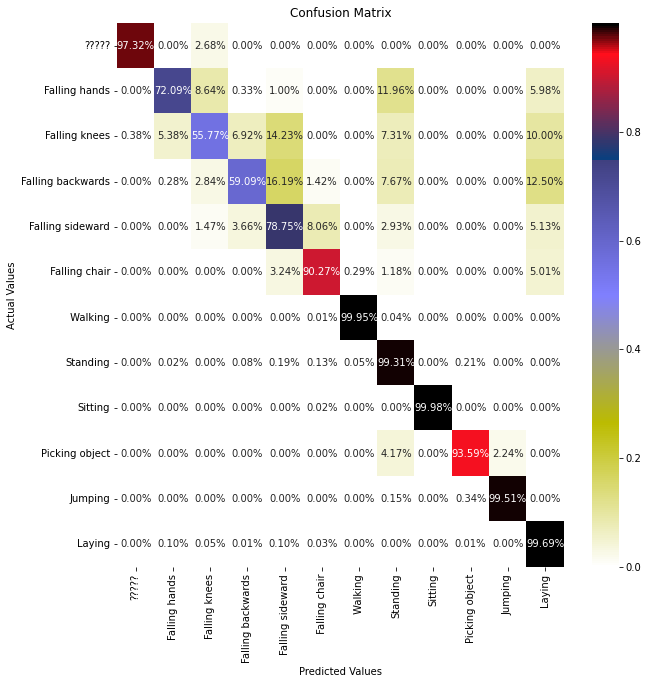

[0.9732, 0.7209, 0.5577, 0.5909, 0.7875, 0.9027, 0.9995, 0.9931, 0.9998, 0.9359, 0.9951, 0.9969]
[98.47, 78.91, 63.04, 69.33, 67.93, 88.18, 99.94, 99.14, 99.99, 90.54, 99.68, 99.43]


In [ ]:
up_model = model_concat()
up_model.summary()




up_model.compile(
#                  optimizer = tf.keras.optimizers.RMSprop(7e-5), 
                 optimizer = tf.keras.optimizers.Adam(),
                #  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-08, decay=0.0),
                #  optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD"),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )

f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_concat.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')

# history_2 = up_model.fit(x = [X_train_1_scaled, X_train_2_scaled] , 
#                       y=  Y_train_2,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = ([X_val_1_scaled,X_val_2_scaled] , Y_val_2),
#                       callbacks = [f1_callback_concat]
#                      )


print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_concat.hdf5")
print(up_model.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
print(up_model.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


y_val = np.argmax(up_model.predict([X_val_1_scaled,X_val_2_scaled] ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict([X_test_1_scaled,X_test_2_scaled] ), axis = 1 )
display_result(y_test_2, y_test)

dd = draw_cm(y_test_2,y_test)
print(dd)


take_f1_Score(y_test_2,y_test)


In [ ]:
print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_concat.hdf5")
print(up_model.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
print(up_model.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


y_val = np.argmax(up_model.predict([X_val_1_scaled,X_val_2_scaled] ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict([X_test_1_scaled,X_test_2_scaled] ), axis = 1 )
display_result(y_test_2, y_test)

best model: 
1614/1614 [==============================] - 10s 6ms/step - loss: 0.0379 - categorical_accuracy: 0.9880 - precision: 0.9892 - recall: 0.9872 - f1_score: 0.9878
[0.03794306889176369, 0.9880092144012451, 0.9892462491989136, 0.987214982509613, 0.9878098964691162]
1614/1614 [==============================] - 9s 6ms/step - loss: 0.0361 - categorical_accuracy: 0.9881 - precision: 0.9893 - recall: 0.9873 - f1_score: 0.9878
[0.036105044186115265, 0.9881060719490051, 0.9892857074737549, 0.987311840057373, 0.9877899885177612]
Accuracy score :  0.9880092206962013
Precision score :  0.9884208955765307
Recall score :  0.9880092206962013
F1 score :  0.9878098123130519
********************
Accuracy score :  0.9881060767487361
Precision score :  0.9881227922854176
Recall score :  0.9881060767487361
F1 score :  0.987789870231769


In [ ]:
# from re import X
def vggg_concat() :
    from keras.layers.pooling import GlobalMaxPooling2D


    def set_seed(num_seed): 
        SEED = num_seed 
        # os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        # tf.compat.v1.keras.backend.set_session(sess)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
      
    def _vgg(input) :
      set_seed(0)
      # img_input = Input(shape=(32,32,1))
      # Block 1
      x = Conv2D(64, (3, 3), activation='relu', padding='same',use_bias=True)(input)
      x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2))(x)

      # Block 2
      x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
      x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2))(x)

      # Block 3
      x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2))(x)

      # Block 4
      x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2))(x)

      # Block 5
      x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2))(x)
      x = GlobalMaxPooling2D()(x)

      # Block 6
      x = Dense(4096, activation='relu')(x)
      x = Dense(4096, activation='relu')(x)
      x = Dense(12, activation='relu')(x)
      # mdl = Model(img_input, x)
      return x


    input1 = Input(shape = (32,32,1))
    output1 = _vgg(input1)
    
    input2 = Input(shape = (32,32,1))
    output2 = _vgg(input2)

    output = Concatenate()([output1,output2])
    output = Dense(12 , activation = 'softmax')(output)
    mdl = Model([input1,input2], output)
    return mdl

up_model = vggg_concat()
up_model.summary()


up_model.compile(
#                  optimizer = tf.keras.optimizers.RMSprop(7e-5), 
                 optimizer = tf.keras.optimizers.Adam(),
                #  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-08, decay=0.0),
                #  optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD"),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )

f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_vgg_concat.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')

history_2 = up_model.fit(x = [X_train_1_scaled,X_train_2_scaled] , 
                      y=  Y_train_1,           
                      epochs= 30, 
                      batch_size = 2**10 , 
                      validation_data = ([X_val_1_scaled,X_val_2_scaled] , Y_val_1),
                      callbacks = [f1_callback_concat]
                     )

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_52 (Conv2D)             (None, 32, 32, 64)   640         ['input_7[0][0]']                
                                                                                                  
 conv2d_65 (Conv2D)             (None, 32, 32, 64)   640         ['input_8[0][0]']                
                                                                                            

In [ ]:
print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_2_vgg_concat.hdf5")
print(up_model.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
print(up_model.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


y_val = np.argmax(up_model.predict([X_val_1_scaled,X_val_2_scaled] ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict([X_test_1_scaled,X_test_2_scaled] ), axis = 1 )
display_result(y_test_2, y_test)

best model: 
1614/1614 [==============================] - 24s 14ms/step - loss: 1.7487 - categorical_accuracy: 0.2777 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1207
[1.748652458190918, 0.2777444124221802, 0.0, 0.0, 0.12074708938598633]
1614/1614 [==============================] - 23s 14ms/step - loss: 1.7464 - categorical_accuracy: 0.2787 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1215
[1.7464139461517334, 0.27865487337112427, 0.0, 0.0, 0.12145347893238068]
Accuracy score :  0.2777444162485714
Precision score :  0.07714196075725968
Recall score :  0.2777444162485714
F1 score :  0.12074709116514354
********************


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score :  0.2786548631423978
Precision score :  0.07764853275290844
Recall score :  0.2786548631423978
F1 score :  0.1214534664375043


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# UP-3
[link](https://sci-hub.se/10.1109/icacsis51025.2020.9263201)

## IMG1

In [ ]:
def model_1 () :
    def set_seed(num_seed): 
        SEED = num_seed 
        # os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        # tf.compat.v1.keras.backend.set_session(sess)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
      
    set_seed(0)
    input = Input(shape = (32, 32, 1))

    x = Conv2D(filters = 8,
              kernel_size = (3,3) ,
              activation = tf.nn.relu,
              strides=(2, 2),
              padding = 'same' )(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # for filter in [16,16] :
    x = Conv2D(filters = 16,
          kernel_size = (3,3) ,
          activation = tf.nn.relu,
          padding = 'same' )(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters = 16,
          kernel_size = (3,3) ,
          activation = tf.nn.relu,
          padding = 'same' )(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    output = Dense(12, activation = 'softmax')(x)
    
    model = Model(inputs= input, outputs=output)

    return model 

up_model = model_1()
up_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 8)         80        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 8, 8, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 16)          1168      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 16)          2320

In [ ]:
up_model = model_1()
up_model.summary()

up_model.compile(
#                  optimizer = tf.keras.optimizers.RMSprop(7e-5), 
#                  optimizer = tf.keras.optimizers.Adam(7e-5),
                #  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-08, decay=0.0),
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD"),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )

f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_3_1.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')

# history_2 = up_model.fit(x = X_train_1_scaled , 
#                       y=  Y_train_1,           
#                       epochs= 30, 
#                       batch_size =  100 , 
#                       validation_data = (X_val_1_scaled , Y_val_1),
#                       callbacks = [f1_callback_concat]
#                      )


print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_3_1.hdf5")
print(up_model.evaluate(X_val_1_scaled , Y_val_1))
print(up_model.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(up_model.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)


Epoch 1/30
1549/1549 [==============================] - ETA: 0s - loss: 1.9371 - categorical_accuracy: 0.2746 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1576
Epoch 1: val_f1_score improved from -inf to 0.12075, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_3_1.hdf5
1549/1549 [==============================] - 21s 6ms/step - loss: 1.9371 - categorical_accuracy: 0.2746 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1576 - val_loss: 1.7318 - val_categorical_accuracy: 0.2777 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.1207
Epoch 2/30
1544/1549 [============================>.] - ETA: 0s - loss: 1.7126 - categorical_accuracy: 0.2786 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1215
Epoch 2: val_f1_score improved from 0.12075 to 0.12683, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_3_1.hdf5
1549/1549 [==============================] - 8s

In [ ]:

print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_3_1.hdf5")
print(up_model.evaluate(X_val_1_scaled , Y_val_1))
print(up_model.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(up_model.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)


best model: 
1614/1614 [==============================] - 6s 3ms/step - loss: 0.4188 - categorical_accuracy: 0.8843 - precision: 0.9043 - recall: 0.8670 - f1_score: 0.8644
[0.41879937052726746, 0.8842957615852356, 0.9043058156967163, 0.866958498954773, 0.8643816709518433]
1614/1614 [==============================] - 5s 3ms/step - loss: 0.4207 - categorical_accuracy: 0.8835 - precision: 0.9041 - recall: 0.8662 - f1_score: 0.8636
[0.4206743538379669, 0.8835402727127075, 0.9041370153427124, 0.8661836981773376, 0.8636071085929871]
Accuracy score :  0.88429575964202
Precision score :  0.8511014176538052
Recall score :  0.88429575964202
F1 score :  0.8643816644874259
********************


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score :  0.8835402824322492
Precision score :  0.8506200732493814
Recall score :  0.8835402824322492
F1 score :  0.8636070746069042


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## IMG2

In [ ]:
up_model = model_1()
up_model.summary()

up_model.compile(
#                  optimizer = tf.keras.optimizers.RMSprop(7e-5), 
#                  optimizer = tf.keras.optimizers.Adam(7e-5),
                #  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-08, decay=0.0),
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD"),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )

f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_3_2.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')

# history_2 = up_model.fit(x = X_train_2_scaled , 
#                       y=  Y_train_2,           
#                       epochs= 30, 
#                       batch_size =  100 , 
#                       validation_data = (X_val_2_scaled , Y_val_2),
#                       callbacks = [f1_callback_concat]
#                      )


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 16)          1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 16)          2320

In [ ]:

print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_3_2.hdf5")
print(up_model.evaluate(X_val_2_scaled , Y_val_2))
print(up_model.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(up_model.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)

best model: 
1614/1614 [==============================] - 14s 3ms/step - loss: 0.3999 - categorical_accuracy: 0.8819 - precision: 0.9005 - recall: 0.8684 - f1_score: 0.8652
[0.3998931050300598, 0.8818937540054321, 0.9005283117294312, 0.8684307336807251, 0.865187406539917]
1614/1614 [==============================] - 5s 3ms/step - loss: 0.3982 - categorical_accuracy: 0.8826 - precision: 0.9021 - recall: 0.8695 - f1_score: 0.8657
[0.39819085597991943, 0.8825523257255554, 0.9020841121673584, 0.8694767951965332, 0.8657238483428955]
Accuracy score :  0.8818937295391589
Precision score :  0.8526690798697429
Recall score :  0.8818937295391589
F1 score :  0.8651873975543772
********************


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score :  0.882552350696395
Precision score :  0.8522459537212461
Recall score :  0.882552350696395
F1 score :  0.8657238956303404


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

print("best model: ")
up_model.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Comparision/up_3_2.hdf5")
print(up_model.evaluate(X_val_1_scaled , Y_val_1))
print(up_model.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(up_model.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(up_model.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)

best model: 
1614/1614 [==============================] - 5s 3ms/step - loss: 8.9253 - categorical_accuracy: 0.1626 - precision: 0.1625 - recall: 0.1609 - f1_score: 0.0537
[8.925275802612305, 0.16258257627487183, 0.1625021994113922, 0.16087789833545685, 0.05372505635023117]
1614/1614 [==============================] - 5s 3ms/step - loss: 8.9020 - categorical_accuracy: 0.1652 - precision: 0.1653 - recall: 0.1637 - f1_score: 0.0547
[8.901996612548828, 0.1651976853609085, 0.16529104113578796, 0.16370609402656555, 0.05471010133624077]
Accuracy score :  0.16258256978478586
Precision score :  0.0341425379277447
Recall score :  0.16258256978478586
F1 score :  0.05372505267744077
********************


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score :  0.16519768320322337
Precision score :  0.0348694749368162
Recall score :  0.16519768320322337
F1 score :  0.05471010043440639


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
